Copyright 2021 DeepMind Technologies Limited.


Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [ ]:
import bandit
import multiarm_model
import arm_model
import agents as agent_classes
import kernel as kernel_classes

import random
from typing import List, Dict
import pickle as pkl
from scipy import spatial
import numpy as np
import copy
import matplotlib.pyplot as plt
%matplotlib inline

Function to run a single experiment with a list of agents.

In [ ]:
def run_experiment(agents: Dict[str, agent_classes.Agent], world, n_steps: int,
                   best_mean: float,
                   true_mean: np.ndarray) -> Dict[str, List[float]]:
  """Given a number of agents, run one experiments with world for n_steps."""
  current_sim_regrets = {name: [] for name in agents}
  for _ in range(n_steps):
    for agent_name in agents:
      a = agents[agent_name].select_action()
      r = world.pull(a)
      agents[agent_name].update(a, r)
      current_sim_regrets[agent_name].append(
          best_mean - true_mean[agents[agent_name].best_arm])
  return current_sim_regrets

Function to read actions of the policies and to compute the kernel based on them.

In [ ]:
def get_experiment_distances(policies: Dict[str, float]):
  """Get the policy distances of the current experiment."""
  # Load actions that the policies take.
  with open('./data/actions.pkl', 'rb') as f:
    actions_policy_keys_in_distances = pkl.load(f)
  all_predictions = actions_policy_keys_in_distances['actions']
  policy_keys_in_distances = actions_policy_keys_in_distances['policy_keys']

  # Compute distances between actions.
  all_distances = []
  for i in range(np.shape(np.array(all_predictions))[0]):
    distance = spatial.distance.cdist(
        np.array(all_predictions)[i, :, :],
        np.array(all_predictions)[i, :, :], 'euclidean')
    all_distances.append(distance)
  distances = np.mean(np.array(all_distances), axis=0)

  # Depending on a subset of selected policies and their order, get a smaller distance matrix.
  experiment_distances = kernel_classes.select_experiment_distances(
      policies, policy_keys_in_distances, distances)
  return experiment_distances

Get samples of the policies returns.

In [ ]:
with open('./data/full_reward_samples.pkl', 'rb') as f:
  full_reward_samples_dict = pkl.load(f)

Load information about the policies: their ids, FQE estimates and GT performance.

In [ ]:
with open('./data/ope_values.pkl', 'rb') as f:
  ope_values = pkl.load(f)

Experimental parameters.

In [ ]:
n_experiments = 100  # @param
n_steps = 100  # @param
num_policies = 50  # @param
use_fqe = True  # @param
use_prior = False

if not use_fqe:
  use_prior = True

# GP optimizer
optimizer_config = dict(
    optimizer_name='Adam',
    learning_rate=0.001,
    steps_per_update=1000,
    kwargs=dict(
        beta1=0.9,
        beta2=0.999,
    ),
)

# Priors.
arm_kwargs = [{
    'prior_mean': 0.0,
    'prior_std': 1000.,
    'alpha': 1.,
    'beta': 1000.,
    'sample': False,
    'steps': 10,
    'burnin': 0
} for _ in range(num_policies)]
prior = dict(use_prior=use_prior, alpha=1., beta=200.)

sim_regrets = None
regrets_fqe = []

Run the experiment!

Please note that it may take several hours to run the full experiment. For experimentation purposes, in order to get the results faster, the number of runs and the number of steps may be reduced. To verify that the code runs you can start with 10 experiments (n_experiments) with 10 steps (n_steps).

In [ ]:
for _ in range(n_experiments):
  print(_)
  # Make a world with randomly selected policies.
  np.random.seed(seed=805 + _)
  # selected_policies_fqe = task_data.iloc[np.random.choice(len(task_data), num_policies, replace=False)]
  selected_policies_fqe = dict(
      random.sample(ope_values.items(), k=num_policies))

  world = bandit.MAB(selected_policies_fqe)
  world.load_reward_samples(full_reward_samples_dict)

  true_mean = np.array([np.mean(rs) for rs in world._rewards])
  best_mean = true_mean.max()

  # FQE instead of a-ops.
  regret_fqe = best_mean - true_mean[np.argmax(world.opes)]
  regrets_fqe.append(regret_fqe)

  # Independent arm model.

  model_ind = multiarm_model.IndependentMultiArmModel(
      world.num_arms,
      arm_model.SingleBayesArm,
      arm_args=None,
      arm_kwargs=arm_kwargs)
  if use_fqe:
    for a in range(len(world.opes)):
      model_ind.update(a, world.opes[a])

  # Kernel for GP.
  experiment_distances = get_experiment_distances(
      policies=selected_policies_fqe)
  kernel = kernel_classes.ActionDistanceMatern12(
      experiment_distances,
      lengthscale=np.median(experiment_distances),
      bias_variance=10.,
      variance_prior=prior)

  # GP as arm model.
  model_gp = multiarm_model.MVNormal(
      num_arms=world.num_arms,
      offset=0.,
      kernel=kernel,
      observation_noise_variance=1000.,
      optimizer_config=optimizer_config,
      observation_noise_variance_prior=prior)
  if use_fqe:
    for a in range(len(world.opes)):
      model_gp.update(a, world.opes[a])

  # Make agents.
  agent_ind_uniform = agent_classes.UniformAgent(copy.deepcopy(model_ind))
  agent_gp_uniform = agent_classes.UniformAgent(copy.deepcopy(model_gp))
  if use_fqe:
    agent_ind_ucb = agent_classes.UCBAgent(
        copy.deepcopy(model_ind), exploration_coef=5)
    agent_gp_ucb = agent_classes.UCBAgent(
        copy.deepcopy(model_gp), exploration_coef=5)
  # If no FQE is available at the start, first sample a few datapoints.
  else:
    agent_ind_ucb = agent_classes.UCBAgent(
        copy.deepcopy(model_ind), exploration_coef=5, initial_rand_samples=5)
    agent_gp_ucb = agent_classes.UCBAgent(
        copy.deepcopy(model_gp), exploration_coef=5, initial_rand_samples=5)
  agents = {
      'Ind+Uniform+OPE': agent_ind_uniform,
      'Ind+UCB+OPE': agent_ind_ucb,
      'GP+Uniform+OPE': agent_gp_uniform,
      'A-ops': agent_gp_ucb
  }

  # Run experiment and collect results data.
  current_sim_regrets = run_experiment(
      agents=agents,
      world=world,
      n_steps=n_steps,
      best_mean=best_mean,
      true_mean=true_mean)

  if sim_regrets is None:
    sim_regrets = {name: [] for name in agents}

  for agent_name in agents:
    sim_regrets[agent_name].append(current_sim_regrets[agent_name])

Plot the regrets.

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)

plt.rc('font', size=8.0)
plt.rc('figure', figsize=(2, 1.5))
plt.rc('axes', linewidth=0.5, titlesize=6.0)
plt.rc('legend', fontsize=7.0, frameon=False)
plt.rc('lines', markersize=1, linewidth=0.5)
plt.rc('xtick', direction='out')
plt.rc('ytick', direction='out')

n_steps = len(sim_regrets['Ind+Uniform+OPE'][0])
line_colors = {
    'Ind+Uniform+OPE': plt.cm.Paired(3),
    'Ind+UCB+OPE': plt.cm.Paired(3),
    'GP+Uniform+OPE': plt.cm.Paired(9),
    'A-ops': plt.cm.Paired(9)
}
fill_colors = {
    'Ind+Uniform+OPE': plt.cm.Paired(2),
    'Ind+UCB+OPE': plt.cm.Paired(3),
    'GP+Uniform+OPE': plt.cm.Paired(8),
    'A-ops': plt.cm.Paired(9)
}
line_styles = {
    'Ind+Uniform+OPE': '--',
    'Ind+UCB+OPE': '-',
    'GP+Uniform+OPE': '--',
    'A-ops': '-'
}

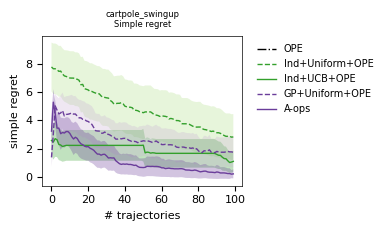

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])

# Plot OPE performance with standard deviation
regret_fqe = np.mean(np.array(regrets_fqe))
regret_std = np.std(np.array(regrets_fqe))
plt.plot([0, n_steps - 1], [regret_fqe, regret_fqe],
         '-.',
         lw=1,
         color='black',
         label='OPE')
plt.fill_between([0, n_steps - 1],
                 [regret_fqe - regret_std / 2, regret_fqe - regret_std / 2],
                 [regret_fqe + regret_std / 2, regret_fqe + regret_std / 2],
                 color='k',
                 alpha=0.05,
                 linewidth=0.0)

# Plot agent's performance with standard deviation
for agent_name in sim_regrets:
  regret_agent = np.mean(np.array(sim_regrets[agent_name]), axis=0)
  regret_std = np.std(np.array(sim_regrets[agent_name]), axis=0)
  plt.plot(
      range(n_steps),
      regret_agent,
      line_styles[agent_name],
      lw=1,
      color=line_colors[agent_name],
      label=agent_name)
  plt.fill_between(
      range(n_steps),
      regret_agent - regret_std / 2,
      regret_agent + regret_std / 2,
      facecolor=fill_colors[agent_name],
      alpha=0.3,
      linewidth=0.0)

plt.xlabel('# trajectories')
plt.ylabel('simple regret')
plt.title('cartpole_swingup' + '\nSimple regret')
plt.legend(loc='upper right', ncol=1, bbox_to_anchor=(1.7, 1))
plt.show()